In [4]:
import pandas as pd

df = pd.read_parquet('files_parquet/df_baseFinal.parquet', engine='pyarrow')
df[['temporada', 'nombre_categoria_producto', 'peso_producto_g', 
            'largo_producto_cm', 'altura_producto_cm', 'ancho_producto_cm', 
            'ciudad_cliente', 'estado_cliente',"id_producto"]]


,temporada,nombre_categoria_producto,peso_producto_g,largo_producto_cm,altura_producto_cm,ancho_producto_cm,ciudad_cliente,estado_cliente,id_producto
1,Primavera,informatica_acessorios,150,16,13,14,nova iguacu,RJ,0d85c435fd60b277ffb9e9b0f88f927a
2,Verano,cama_mesa_banho,750,16,10,16,pouso alegre,MG,364e789259da982f5b7e43aaea7be615
4,Invierno,cama_mesa_banho,550,40,7,50,sao paulo,SP,b7605b5b483063d12bd90a772bff9d21
6,Invierno,brinquedos,4017,38,35,42,sao paulo do potengi,RN,8100d323ffa1909cfcf9fdf05f20b678
7,Invierno,eletronicos,150,25,7,16,itaborai,RJ,566a4f2c4385f36d15c00dfcaae132d1
...,...,...,...,...,...,...,...,...,...
116567,Primavera,esporte_lazer,250,22,14,11,belo horizonte,MG,cb92637d91f8267856d2143b6fc7bd9e
116578,Invierno,bebes,4950,40,10,40,praia grande,SP,f1d4ce8c6dd66c47bbaa8c6781c2a923
116580,Invierno,informatica_acessorios,6550,20,20,20,japuiba,RJ,d1c427060a0f73f6b889a5c7c61f2ac4
116581,Invierno,informatica_acessorios,6550,20,20,20,japuiba,RJ,d1c427060a0f73f6b889a5c7c61f2ac4


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Cargar la base de datos
df = pd.read_parquet('files_parquet/df_baseFinal.parquet', engine='pyarrow')

# Selección de características relevantes para la predicción
features = ['temporada', 'nombre_categoria_producto', 'peso_producto_g', 
            'largo_producto_cm', 'altura_producto_cm', 'ancho_producto_cm', 
            'ciudad_cliente', 'estado_cliente', "id_producto"]
target = 'precio'

# Preparar datos
X = df[features]
y = df[target]

# Preprocesamiento de datos
numerical_features = ['peso_producto_g', 'largo_producto_cm', 'altura_producto_cm', 'ancho_producto_cm']
categorical_features = ['temporada', 'nombre_categoria_producto', 'ciudad_cliente', 'estado_cliente', "id_producto"]

# Transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Construcción del modelo con pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir parámetros para la búsqueda de hiperparámetros con GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 6, 9],
    'regressor__subsample': [0.7, 0.8, 0.9],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9],
    'regressor__gamma': [0, 0.1, 0.2],
    'regressor__reg_alpha': [0, 0.01, 0.1]
}

# Búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Entrenamiento del modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Mejor modelo y sus parámetros
best_model = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")

# Predicción con el mejor modelo
y_pred = best_model.predict(X_test)

# Calcular MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# Calcular RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calcular R² (Coeficiente de Determinación)
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

# Evaluación con validación cruzada
cross_val_rmse = np.sqrt(-cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error').mean())
print(f"Cross-validated RMSE: {cross_val_rmse}")



Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Best parameters found: {'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0.1, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 9, 'regressor__n_estimators': 300, 'regressor__reg_alpha': 0.01, 'regressor__subsample': 0.8}
Root Mean Squared Error (RMSE): 132.66767307696477
Mean Absolute Error: 54.75543147112138
R²: 0.5368597466258211
Cross-validated RMSE: 127.5621907889221
Predicted Seasonal Price: 61.67259979248047


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Cargar la base de datos
df = pd.read_parquet('files_parquet/df_baseFinal.parquet', engine='pyarrow')

# Selección de características relevantes para la predicción
features = ['temporada', 'nombre_categoria_producto', 'peso_producto_g', 
            'largo_producto_cm', 'altura_producto_cm', 'ancho_producto_cm', 
            'ciudad_cliente', 'estado_cliente', "id_producto"]
target = 'precio'

# Preparar datos
X = df[features]
y = df[target]

# Preprocesamiento de datos
numerical_features = ['peso_producto_g', 'largo_producto_cm', 'altura_producto_cm', 'ancho_producto_cm']
categorical_features = ['temporada', 'nombre_categoria_producto', 'ciudad_cliente', 'estado_cliente', "id_producto"]

# Transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Construcción del modelo con pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir parámetros para la búsqueda de hiperparámetros con RandomizedSearchCV
param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2'],  
    'regressor__bootstrap': [True, False]
}

# Búsqueda de hiperparámetros con RandomizedSearchCV
random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42,
    scoring='neg_mean_squared_error'
)

# Entrenamiento del modelo con RandomizedSearchCV
random_search.fit(X_train, y_train)

# Mejor modelo y sus parámetros
best_model = random_search.best_estimator_
print(f"Best parameters found: {random_search.best_params_}")

# Predicción con el mejor modelo
y_pred = best_model.predict(X_test)

# Calcular MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# Calcular RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calcular MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calcular R² (Coeficiente de Determinación)
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

# Evaluación con validación cruzada
cross_val_rmse = np.sqrt(-cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error').mean())
print(f"Cross-validated RMSE: {cross_val_rmse}")

# Ejemplo de predicción para un nuevo dato
new_data = pd.DataFrame({
    'temporada': ['Invierno'],
    'nombre_categoria_producto': ['cama_mesa_banho'],
    'id_producto': ['364e789259da982f5b7e43aaea7be61'],
    'peso_producto_g': [750],
    'largo_producto_cm': [16],
    'altura_producto_cm': [10],
    'ancho_producto_cm': [16],
    'ciudad_cliente': ['sao_paulo'],
    'estado_cliente': ['SP']
})
predicted_price = best_model.predict(new_data)
print(f"Predicted Seasonal Price: {predicted_price[0]}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'log2', 'regressor__max_depth': None, 'regressor__bootstrap': False}
Root Mean Squared Error (RMSE): 135.53097390613502
Mean Absolute Error: 43.08639349256335
R²: 0.5166525593367974
Cross-validated RMSE: 132.0407051478721
Predicted Seasonal Price: 52.15767499999999


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Cargar la base de datos
df = pd.read_parquet('files_parquet/df_baseFinal.parquet', engine='pyarrow')

# Selección de características relevantes para la predicción
features = ['temporada', 'nombre_categoria_producto', 'peso_producto_g', 
            'largo_producto_cm', 'altura_producto_cm', 'ancho_producto_cm', 
            'ciudad_cliente', 'estado_cliente', "id_producto"]
target = 'precio'

# Preparar datos
X = df[features]
y = df[target]

# Preprocesamiento de datos
numerical_features = ['peso_producto_g', 'largo_producto_cm', 'altura_producto_cm', 'ancho_producto_cm']
categorical_features = ['temporada', 'nombre_categoria_producto', 'ciudad_cliente', 'estado_cliente', "id_producto"]

# Transformaciones
preprocessor = ColumnTransformer(
    transformers=[ 
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Construcción del modelo con pipeline usando regresión lineal
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo
model.fit(X_train, y_train)

# Predicción con el modelo entrenado
y_pred = model.predict(X_test)

# Calcular MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# Calcular RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calcular MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calcular R² (Coeficiente de Determinación)
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

# Evaluación con validación cruzada
cross_val_rmse = np.sqrt(-cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error').mean())
print(f"Cross-validated RMSE: {cross_val_rmse}")

# Ejemplo de predicción para un nuevo dato
new_data = pd.DataFrame({
    'temporada': ['Invierno'],
    'nombre_categoria_producto': ['cama_mesa_banho'],
    'id_producto': ['364e789259da982f5b7e43aaea7be61'],
    'peso_producto_g': [750],
    'largo_producto_cm': [16],
    'altura_producto_cm': [10],
    'ancho_producto_cm': [16],
    'ciudad_cliente': ['sao_paulo'],
    'estado_cliente': ['SP']
})
predicted_price = model.predict(new_data)
print(f"Predicted Seasonal Price: {predicted_price[0]}")


Root Mean Squared Error (RMSE): 118.00588481246069
Mean Absolute Error: 25.5505433077853
R²: 0.6335711696683618
Cross-validated RMSE: 114.60153311330578
Predicted Seasonal Price: 49.11029012139329


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Cargar la base de datos
df = pd.read_parquet('files_parquet/df_baseFinal.parquet', engine='pyarrow')

# Selección de características relevantes para la predicción
features = ['temporada', 'nombre_categoria_producto', 'peso_producto_g', 
            'largo_producto_cm', 'altura_producto_cm', 'ancho_producto_cm', 
            'ciudad_cliente', 'estado_cliente', "id_producto"]
target = 'precio'

# Preparar datos
X = df[features]
y = df[target]

# Preprocesamiento de datos
numerical_features = ['peso_producto_g', 'largo_producto_cm', 'altura_producto_cm', 'ancho_producto_cm']
categorical_features = ['temporada', 'nombre_categoria_producto', 'ciudad_cliente', 'estado_cliente', "id_producto"]

# Transformaciones
preprocessor = ColumnTransformer(
    transformers=[ 
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Construcción del modelo con pipeline usando ElasticNet
model = Pipeline(steps=[ 
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
])

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo
model.fit(X_train, y_train)

# Predicción con el modelo entrenado
y_pred = model.predict(X_test)

# Calcular MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# Calcular RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calcular MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calcular R² (Coeficiente de Determinación)
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

# Evaluación con validación cruzada
cross_val_rmse = np.sqrt(-cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error').mean())
print(f"Cross-validated RMSE: {cross_val_rmse}")

# Ejemplo de predicción para un nuevo dato
new_data = pd.DataFrame({
    'temporada': ['Invierno'],
    'nombre_categoria_producto': ['cama_mesa_banho'],
    'id_producto': ['364e789259da982f5b7e43aaea7be61'],
    'peso_producto_g': [750],
    'largo_producto_cm': [16],
    'altura_producto_cm': [10],
    'ancho_producto_cm': [16],
    'ciudad_cliente': ['sao_paulo'],
    'estado_cliente': ['SP']
})
predicted_price = model.predict(new_data)
print(f"Predicted Seasonal Price: {predicted_price[0]}")


Root Mean Squared Error (RMSE): 183.5302025556967
Mean Absolute Error: 81.10410618258098
R²: 0.11366603331540448
Cross-validated RMSE: 171.0041089083212
Predicted Seasonal Price: 86.0616908926205


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Cargar la base de datos
df = pd.read_parquet('files_parquet/df_baseFinal.parquet', engine='pyarrow')

# Selección de características relevantes para la predicción
features = ['temporada', 'nombre_categoria_producto', 'peso_producto_g', 
            'largo_producto_cm', 'altura_producto_cm', 'ancho_producto_cm', 
            'ciudad_cliente', 'estado_cliente', "id_producto"]
target = 'precio'

# Preparar datos
X = df[features]
y = df[target]

# Preprocesamiento de datos
numerical_features = ['peso_producto_g', 'largo_producto_cm', 'altura_producto_cm', 'ancho_producto_cm']
categorical_features = ['temporada', 'nombre_categoria_producto', 'ciudad_cliente', 'estado_cliente', "id_producto"]

# Transformaciones
preprocessor = ColumnTransformer(
    transformers=[ 
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Construcción del modelo con pipeline usando K-Nearest Neighbors
model = Pipeline(steps=[ 
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajuste de hiperparámetros con GridSearchCV
param_grid = {
    'regressor__n_neighbors': [3, 5, 7, 10],  # Número de vecinos
    'regressor__weights': ['uniform', 'distance'],  # Cómo ponderar los vecinos
    'regressor__p': [1, 2]  # Normas para la distancia (1=Manhattan, 2=Euclidiana)
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros
print(f"Best parameters found: {grid_search.best_params_}")

# Predicción con el modelo ajustado
y_pred = grid_search.best_estimator_.predict(X_test)

# Calcular MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# Calcular RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calcular MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calcular R² (Coeficiente de Determinación)
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

# Evaluación con validación cruzada
cross_val_rmse = np.sqrt(-cross_val_score(grid_search.best_estimator_, X, y, cv=5, scoring='neg_mean_squared_error').mean())
print(f"Cross-validated RMSE: {cross_val_rmse}")

# Ejemplo de predicción para un nuevo dato
new_data = pd.DataFrame({
    'temporada': ['Invierno'],
    'nombre_categoria_producto': ['cama_mesa_banho'],
    'id_producto': ['364e789259da982f5b7e43aaea7be61'],
    'peso_producto_g': [750],
    'largo_producto_cm': [16],
    'altura_producto_cm': [10],
    'ancho_producto_cm': [16],
    'ciudad_cliente': ['sao_paulo'],
    'estado_cliente': ['SP']
})
predicted_price = grid_search.best_estimator_.predict(new_data)
print(f"Predicted Seasonal Price: {predicted_price[0]}")


Best parameters found: {'regressor__n_neighbors': 5, 'regressor__p': 1, 'regressor__weights': 'distance'}
Root Mean Squared Error (RMSE): 142.5360701423
Mean Absolute Error: 39.60580011948025
R²: 0.46539641531214504
Cross-validated RMSE: 137.97945093014545
Predicted Seasonal Price: 58.196000000000005


/tmp/ipykernel_9593/430704319.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(model_names_rmse_sorted, rotation=45)
/tmp/ipykernel_9593/430704319.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(model_names_mae_sorted, rotation=45)
/tmp/ipykernel_9593/430704319.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(model_names_r2_sorted, rotation=45)


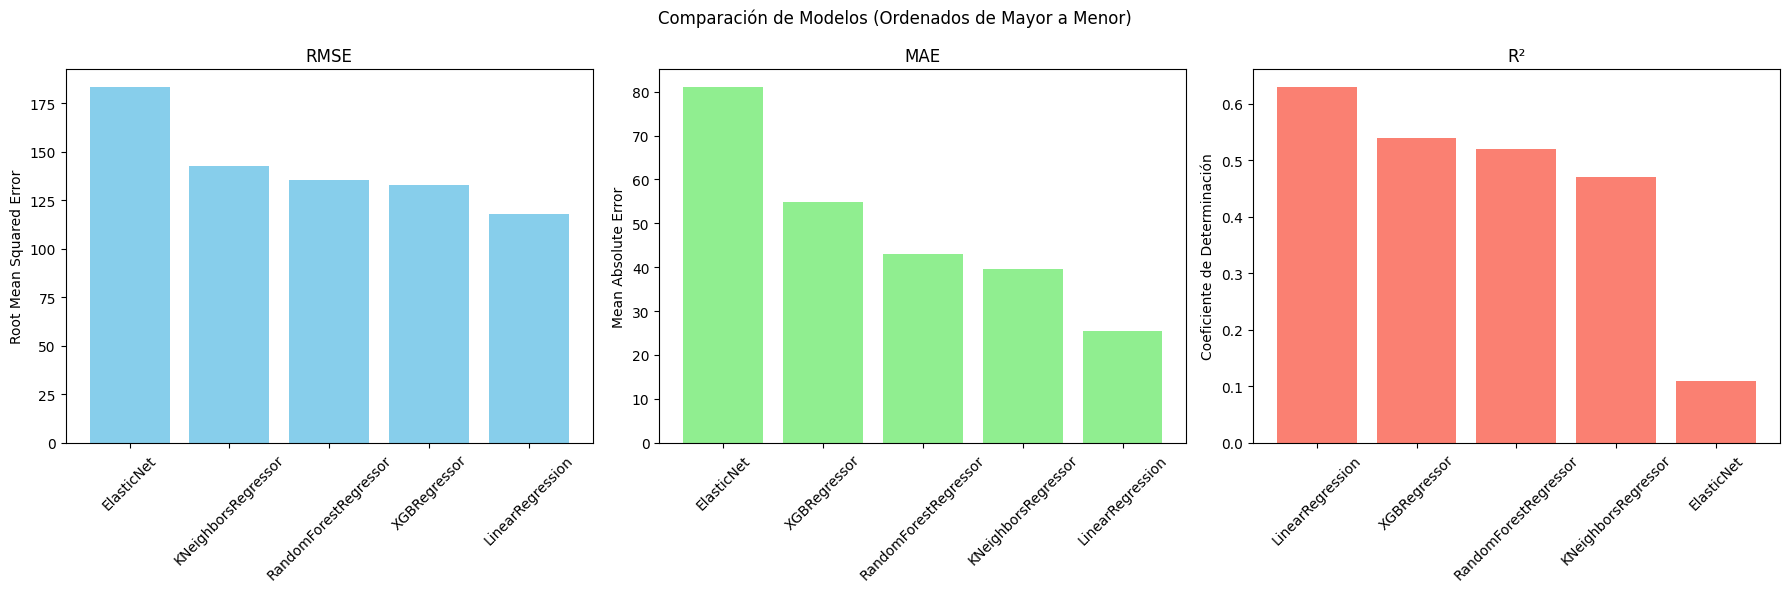

In [8]:
#Comparando modelos
import matplotlib.pyplot as plt
import numpy as np

# Nombres de los modelos
model_names = [
    "XGBRegressor", 
    "RandomForestRegressor", 
    "LinearRegression", 
    "ElasticNet", 
    "KNeighborsRegressor"
]

# Métricas de cada modelo
rmse_scores = [
    132.67,  # XGBRegressor
    135.53,  # RandomForestRegressor
    118.01,  # LinearRegression
    183.53,    # ElasticNet
    142.54   # KNeighborsRegressor
]

mae_scores = [
    54.76,   # XGBRegressor
    43.09,   # RandomForestRegressor
    25.55,   # LinearRegression
    81.10,     # ElasticNet
    39.61    # KNeighborsRegressor
]

r2_scores = [
    0.54,    # XGBRegressor
    0.52,    # RandomForestRegressor
    0.63,    # LinearRegression
    0.11,      # ElasticNet
    0.47     # KNeighborsRegressor
]

# Ordenar las métricas y modelos de mayor a menor
rmse_order = np.argsort(rmse_scores)[::-1]
mae_order = np.argsort(mae_scores)[::-1]
r2_order = np.argsort(r2_scores)[::-1]

# Aplicar el orden a cada lista
rmse_scores_sorted = [rmse_scores[i] for i in rmse_order]
mae_scores_sorted = [mae_scores[i] for i in mae_order]
r2_scores_sorted = [r2_scores[i] for i in r2_order]

model_names_rmse_sorted = [model_names[i] for i in rmse_order]
model_names_mae_sorted = [model_names[i] for i in mae_order]
model_names_r2_sorted = [model_names[i] for i in r2_order]

# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparación de Modelos (Ordenados de Mayor a Menor)')

# Gráfico RMSE
axes[0].bar(model_names_rmse_sorted, rmse_scores_sorted, color='skyblue')
axes[0].set_title('RMSE')
axes[0].set_ylabel('Root Mean Squared Error')
axes[0].set_xticklabels(model_names_rmse_sorted, rotation=45)

# Gráfico MAE
axes[1].bar(model_names_mae_sorted, mae_scores_sorted, color='lightgreen')
axes[1].set_title('MAE')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_xticklabels(model_names_mae_sorted, rotation=45)

# Gráfico R²
axes[2].bar(model_names_r2_sorted, r2_scores_sorted, color='salmon')
axes[2].set_title('R²')
axes[2].set_ylabel('Coeficiente de Determinación')
axes[2].set_xticklabels(model_names_r2_sorted, rotation=45)

# Mostrar los gráficos
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


LinearRegression es claramente el mejor modelo según estas métricas. Tiene los valores de RMSE y MAE más bajos y el valor de R² más alto, lo cual indica que es el modelo más preciso y confiable para este conjunto de datos. Por otro lado, ElasticNet es el menos efectivo, mostrando el peor rendimiento en todas las métricas. Si deseas una alternativa a LinearRegression, XGBRegressor podría ser una opción viable, aunque su rendimiento es inferior.

In [13]:
#Prediccion y sacando la base prueba para el dash
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Cargar la base de datos
df = pd.read_parquet('files_parquet/df_baseFinal.parquet', engine='pyarrow')

# Selección de características relevantes para la predicción
features = ['temporada', 'nombre_categoria_producto', 'peso_producto_g', 
            'largo_producto_cm', 'altura_producto_cm', 'ancho_producto_cm', 
            'ciudad_cliente', 'estado_cliente', "id_producto"]
target = 'precio'

# Preparar datos
X = df[features]
y = df[target]

# Preprocesamiento de datos
numerical_features = ['peso_producto_g', 'largo_producto_cm', 'altura_producto_cm', 'ancho_producto_cm']
categorical_features = ['temporada', 'nombre_categoria_producto', 'ciudad_cliente', 'estado_cliente', "id_producto"]

# Transformaciones
preprocessor = ColumnTransformer(
    transformers=[ 
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Construcción del modelo con pipeline usando regresión lineal
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo
model.fit(X_train, y_train)

# Predicción con el modelo entrenado en el conjunto completo de datos
df['predicted_price'] = model.predict(X)

# Guardar el DataFrame con la columna de predicción añadida
df.to_csv('files_csv/base_dash.csv')
print("Archivo base_dash.csv guardado exitosamente con las predicciones incluidas.")


Archivo base_dash.csv guardado exitosamente con las predicciones incluidas.


###